In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hydrogen as h2

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rc('font', size=20)

# plt.savefig("figures/"+name, dpi=300, bbox_inches="tight")

# Report

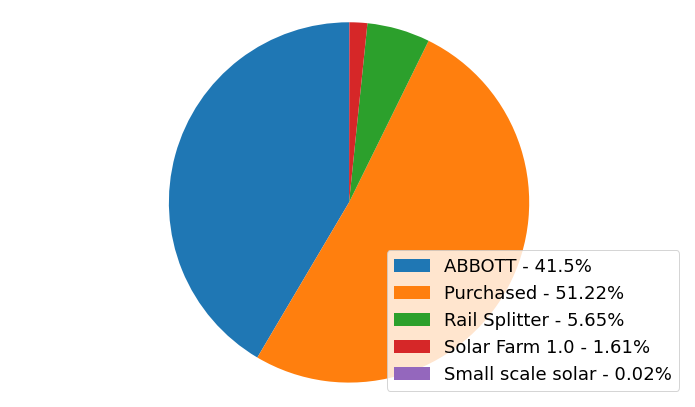

In [2]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'ABBOTT - 41.5%', 'Purchased - 51.22%', 'Rail Splitter - 5.65%', 'Solar Farm 1.0 - 1.61%', 'Small scale solar - 0.02%'
sizes = [41.5, 51.22, 5.65, 1.61, 0.02]

patches, texts = plt.pie(sizes, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("elec-distrib", dpi=300, bbox_inches="tight")

## Solar

In [4]:
df = pd.read_csv('data/2019EnergyData.csv', skiprows=1, parse_dates=True, usecols=['SOLAR FARM 8329E1', 'Unnamed: 33', 'Solar Farm (kw)'])
df.rename(columns={'SOLAR FARM 8329E1':'Date', 'Unnamed: 33':'Time', 'Solar Farm (kw)':'kw'}, inplace=True)

df['time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.index = pd.to_datetime(df.time)
df.drop(columns=['Date', 'Time', 'time'], inplace=True)

df.head(5)

,kw
time,
2018-12-31 22:00:00,-11.510669
2018-12-31 22:01:00,-11.510669
2018-12-31 22:02:00,-11.503946
2018-12-31 22:03:00,-11.495729
2018-12-31 22:04:00,-11.495729


In [5]:
df_hourly = df.resample('H').mean()
df_hourly.index = (df_hourly.index + pd.Timedelta(hours=2))

mask = (df_hourly.index > '2019-6-1') & (df_hourly.index <= '2019-6-30')
newdf = df_hourly.loc[mask]
min_solar = np.nan_to_num(newdf.kw.to_numpy())
index = newdf.index

min_solar /= 1e3
min_solar -= min(min_solar)

min_solar.shape

(696,)

(696,)

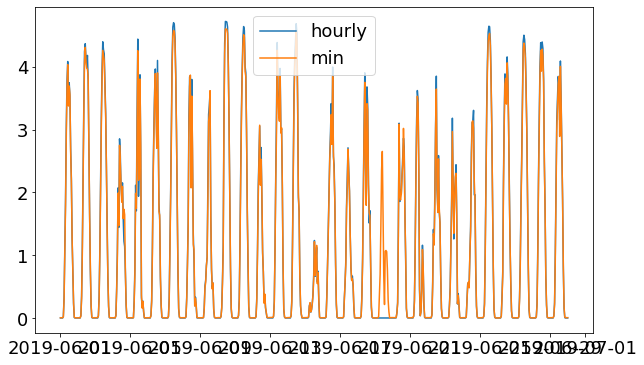

In [6]:
all_data = pd.read_csv("data/solardata.csv", parse_dates=True, index_col='time')
all_hourly = all_data.resample('H').mean()

mask = (all_hourly.index > '2019-6-1') & (all_hourly.index <= '2019-6-30')
newdf = all_hourly.loc[mask]
h_solar = np.nan_to_num(newdf.inverted.to_numpy())
index = newdf.index

# convert to MW
h_solar /= 1e3

plt.plot(index, h_solar, label='hourly')
plt.plot(index, min_solar, label='min')
plt.legend()

h_solar.shape

## Abbott + Ameren

In [7]:
df2 = pd.read_csv('data/2019EnergyData.csv', skiprows=1, parse_dates=True, usecols=['ABBOTT + AMEREN', 'Unnamed: 17', 'Abbott + Ameren (kw)'])
df2.rename(columns={'ABBOTT + AMEREN':'Date', 'Unnamed: 17':'Time', 'Abbott + Ameren (kw)':'kw'}, inplace=True)

df2['time'] = pd.to_datetime(df2['Date'] + ' ' + df2['Time'])
df2.index = pd.to_datetime(df2.time)
df2.drop(columns=['Date', 'Time', 'time'], inplace=True)

df2.head(5)

,kw
time,
2018-12-31 22:00:00,37038.0
2018-12-31 22:01:00,36984.0
2018-12-31 22:02:00,36997.0
2018-12-31 22:03:00,37071.0
2018-12-31 22:04:00,37171.0


In [8]:
df2_hourly = df2.resample('H').mean()
df2_hourly.index = (df2_hourly.index + pd.Timedelta(hours=2))

mask = (df2_hourly.index > '2019-6-1') & (df2_hourly.index <= '2019-6-30')
newdf = df2_hourly.loc[mask]
min_abbotimport = np.nan_to_num(newdf.kw.to_numpy())
index = newdf.index

min_abbotimport /= 1e3
min_abbotimport.shape

(696,)

## Total Demand

In [9]:
df3 = pd.read_csv("data/2014_2019_uiuc_electricity_demand.csv",
                 parse_dates=True,
                 usecols=['time', 'kw'],
                 index_col = ['time'])

mask = (df3.index > '2019-6-1') & (df3.index <= '2019-6-30')
newdf = df3.loc[mask]
demand = newdf[['kw']].to_numpy()
index = newdf.index

demand /= 1e3
demand.shape

(696, 1)

## All together

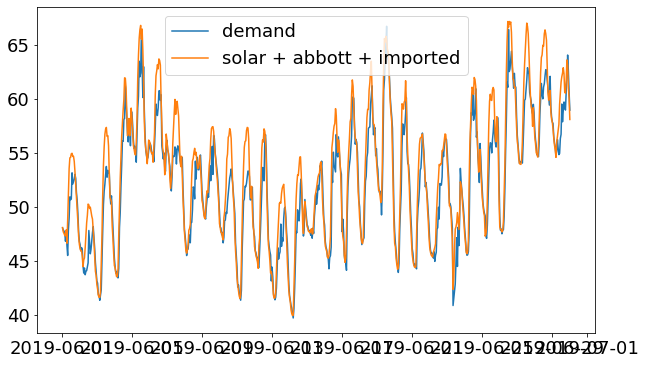

In [10]:
abbotimport = min_abbotimport.reshape(len(min_abbotimport), 1)
solar = min_solar.reshape(len(min_solar), 1)

# demand - (rsolar + rabbotimport)
plt.plot(index, demand, label='demand')
plt.plot(index, (solar + abbotimport), label='solar + abbott + imported')
plt.legend()

## Calculate Imports

In [11]:
df_abbot = pd.read_csv("data/2019_abbott_generation.csv", parse_dates=True, index_col='date')

mask = (df_abbot.index > '2019-6-1') & (df_abbot.index <= '2019-6-30')
newdf = df_abbot.loc[mask]
abbott = newdf[['Value (KW)']].to_numpy()
index = newdf.index

abbott /= 1e3
abbott.shape

(696, 1)

In [12]:
df_wind = pd.read_csv("data/railsplitter-data.csv", parse_dates=True, index_col='Time')

mask = (df_wind.index > '2019-6-1') & (df_wind.index <= '2019-6-30')
newdf = df_wind.loc[mask]
wind = newdf[['MWh']].to_numpy()
index = newdf.index

wind.shape

(696, 1)

Text(0.5, 1.0, 'Scenario0 - Summer month')

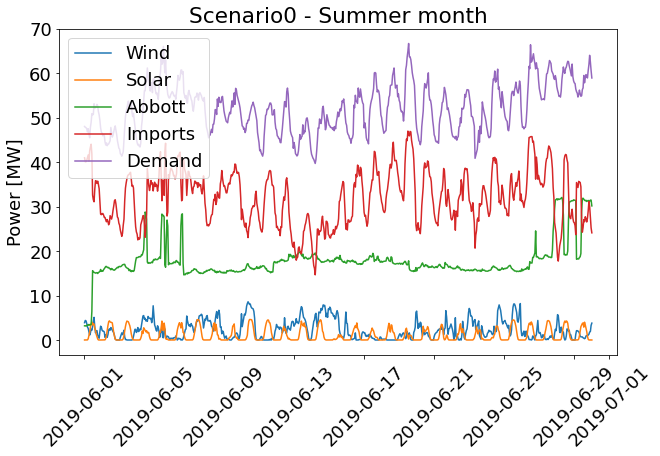

In [13]:
imported = abbotimport - abbott - wind

plt.plot(index, wind, label='Wind')
plt.plot(index, min_solar, label='Solar')
plt.plot(index, abbott, label='Abbott')
plt.plot(index, imported, label='Imports')
plt.plot(index, demand, label='Demand')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Power [MW]')
# plt.xlabel('Date')
plt.title('Scenario0 - Summer month')
# plt.savefig('report/scenario0-summer', dpi=300, bbox_inches="tight")


# CO2 emissions

* Abbott 0.26 tCO2/MWth ??, from Temoa --> 0.26 kilo ton CO2/GWh
* Imported 0.825 tCO2/MWe ??, from Temoa --> 0.825 kilo ton CO2/GWh
* Purchased electricity in 2019: 183,595 MT CO2, from ICAP 2020

In [14]:
abbott_co2 = sum(abbott)/0.6 * 0.26 * 0.907185
imported_co2 = sum(imported) * 0.825 * 0.907185
total0 = abbott_co2[0] + imported_co2[0]

total_co2 = [total0]

print(f'Emissions from Abbott: {abbott_co2[0]} MT CO2')
print(f'Emissions from Imported: {imported_co2[0]} MT CO2')
print(f'Total emissions: {total_co2} MT CO2')

Emissions from Abbott: 4847.821039262812 MT CO2
Emissions from Imported: 16699.313510899738 MT CO2
Total emissions: [21547.134550162547] MT CO2


# Dispatch model 1

* 1- Solar
* 2- Wind
* 3- Abbott -> up to 85 MW
* 4- Imported

Total emissions: 13312.710157801199 MT CO2


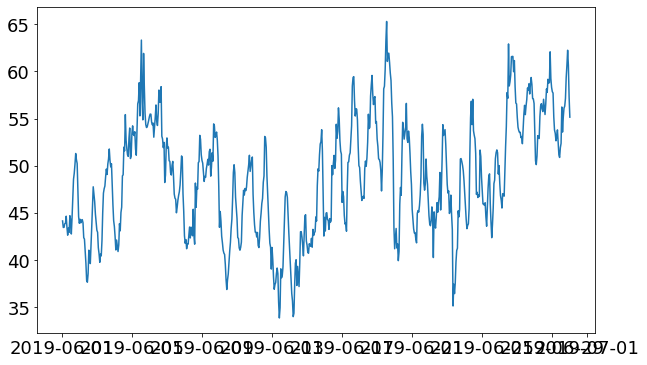

In [15]:
abbott1 = demand - solar - wind
plt.plot(index, abbott1)

total1 = sum(abbott1)/0.6 * 0.26 * 0.907185
total_co2.append(total1)

print(f'Total emissions: {total1[0]} MT CO2')

# Dispatch model 2

* 1- Solar -> 4.68 MW x 2
* 2- Wind -> 8.6% of 100.5 MW x 2
* 3- Abbott -> up to 85 MW
* 4- Imported

Solar max capacity: 9.36 MW
Wind max capacity: 17.285999999999998 MW
Total emissions: 12367.85292229571 MT CO2


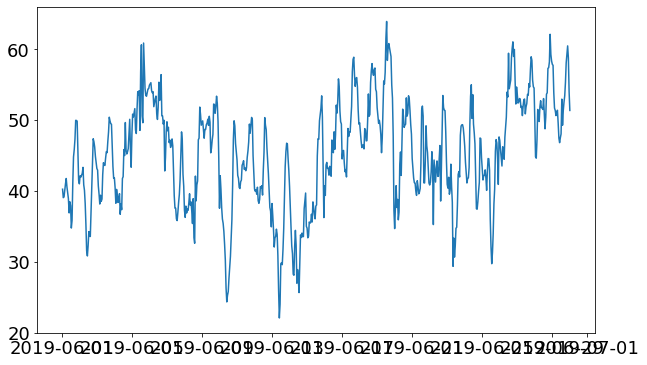

In [16]:
solar2 = solar * 2
wind2 = wind * 2

abbott2 = demand - solar2 - wind2
plt.plot(index, abbott2)

if abbott2.any() <= 0:
    print('We need a battery')

total2 = sum(abbott2)/0.6 * 0.26 * 0.907185
total_co2.append(total2)

print(f'Solar max capacity: {4.68*2} MW')
print(f'Wind max capacity: {8.6*2/100*100.5} MW')
print(f'Total emissions: {total2[0]} MT CO2')

# Dispatch model 3

* 1- Solar -> 4.68 MW x 3
* 2- Wind -> 8.6% of 100.5 MW x 3
* 3- Abbott -> up to 85 MW
* 4- Imported

Solar max capacity: 14.04 MW
Wind max capacity: 25.928999999999995 MW
Total emissions: 11422.995686790196 MT CO2


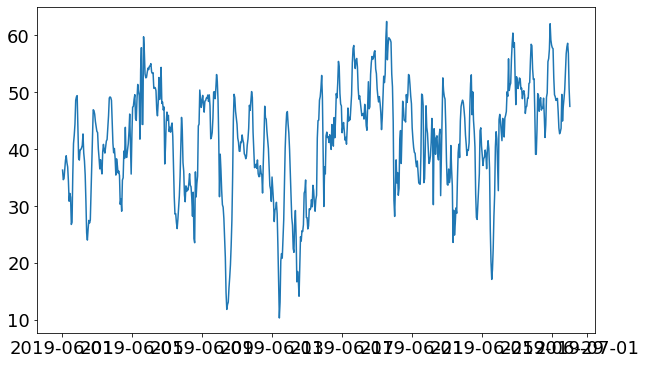

In [17]:
solar3 = solar * 3
wind3 = wind * 3

abbott3 = demand - solar3 - wind3
plt.plot(index, abbott3)

# mask = (index > '2019-6-10') & (index <= '2019-6-14')
# plt.plot(index[mask], abbott3[mask])

if (abbott3 <= 0).any():
    print('We need a battery')

total3 = sum(abbott3)/0.6 * 0.26 * 0.907185
total_co2.append(total3)

print(f'Solar max capacity: {4.68*3} MW')
print(f'Wind max capacity: {8.6*3/100*100.5} MW')
print(f'Total emissions: {total3[0]} MT CO2')

# Dispatch model 4

* 1- Solar -> 4.68 MW x 4
* 2- Wind -> 8.6% of 100.5 MW x 4
* 3- Abbott -> up to 85 MW
* 4- Imported

Storage mechanism: <br />
1- Li-ion batteries, charge-discharge efficiency = 0.85 <br />
2- H2, charge-discharge efficiency = 0.6 * 40/60 = 0.4

In [18]:
def dispatch1(times, eff):
    solar4 = solar * times
    wind4 = wind * times
    abbott4 = demand - solar4 - wind4
    #if (abbott4 <= 0).any():
    #    print('We need a storage mechanism')

    excess = abbott4.copy()
    excess[excess > 0] = 0
    abbott4[abbott4 < 0] = 0
    excess *= -1
    stored = np.roll(eff*excess, 1)
    totalA = sum(abbott4)/0.6 * 0.26 * 0.907185

    original_abbott4 = abbott4.copy()
    original_stored = stored.copy()
    
    for i in range(len(solar4)):
        if stored[i] > 0:
            if stored[i] <= abbott4[i]:
                abbott4[i] -= stored[i]
                stored[i] = 0
            else:
                if i < len(solar4)-1:
                    stored[i] -= abbott4[i]
                    stored[i+1] += stored[i]
                    stored[i] = 0
                else:
                    stored[i] -= abbott4[i]
                abbott4[i] = 0
    
    total4 = sum(abbott4)/0.6 * 0.26 * 0.907185
    solar_max = 4.68*times
    wind_max = 8.6*times/100*100.5
    return solar_max, wind_max, total4[0], max(original_stored)[0]

In [19]:
# Battery
solar_max, wind_max, co2, store_max = dispatch1(4, 0.85)
print(f'Solar max capacity: {solar_max} MW')
print(f'Wind max capacity: {wind_max} MW')
print(f'Total emissions: {co2} MT CO2')
print(f'Battery charge power: {store_max} MW')

Solar max capacity: 18.72 MW
Wind max capacity: 34.571999999999996 MW
Total emissions: 10478.264779613677 MT CO2
Battery charge power: 1.2277803713651152 MW


In [20]:
# Hydrogen
solar_max, wind_max, co2, store_max = dispatch1(4, 0.4)
print(f'Solar max capacity: {solar_max} MW')
print(f'Wind max capacity: {wind_max} MW')
print(f'Total emissions: {co2} MT CO2')
print(f'Battery charge power: {store_max} MW')
print(f'Hydrogen prod rate: {store_max*1e3/0.6/40} kg/h')

Solar max capacity: 18.72 MW
Wind max capacity: 34.571999999999996 MW
Total emissions: 10478.643764600562 MT CO2
Battery charge power: 0.577778998289466 MW
Hydrogen prod rate: 24.074124928727752 kg/h


# Putting all together

Text(0.5, 1.0, 'Scenario1 - Summer')

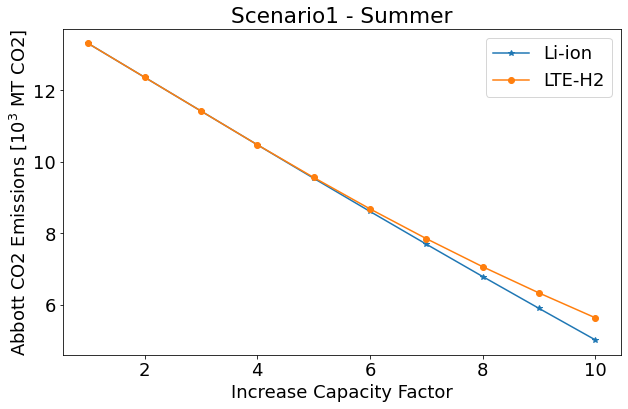

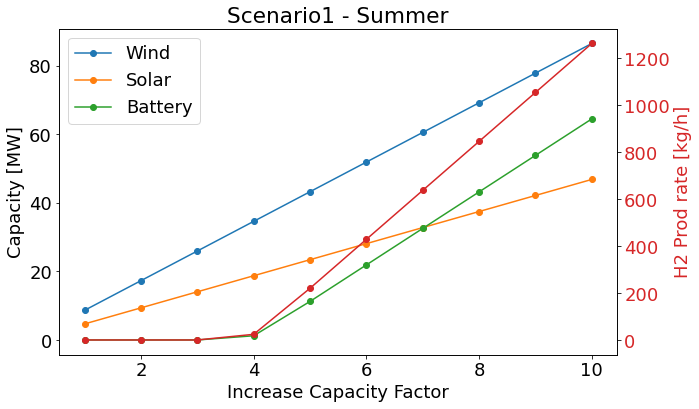

In [24]:
solar_cap = []
wind_cap = []
battery_co2 = []
battery_cap = []
hydrogen_co2 = []
hydrogen_rate = []

for times in range(1, 11):
    # Battery
    solar_max, wind_max, co2, store_max = dispatch1(times, 0.85)
    solar_cap.append(solar_max)
    wind_cap.append(wind_max)
    battery_co2.append(co2/1e3)
    battery_cap.append(store_max)

    # Hydrogen
    solar_max, wind_max, co2, store_max = dispatch1(times, 0.4)
    hydrogen_co2.append(co2/1e3)
    hydrogen_rate.append(store_max*1e3/0.6/40)

plt.plot(np.arange(1, 11), battery_co2, marker='*', label='Li-ion')
plt.plot(np.arange(1, 11), hydrogen_co2, marker='o', label='LTE-H2')
plt.legend()
plt.ylabel(r'Abbott CO2 Emissions [10$^3$ MT CO2]')
plt.xlabel('Increase Capacity Factor')
plt.title('Scenario1 - Summer')
# plt.savefig('report/scenario1-summerA', dpi=300, bbox_inches="tight")

fig, ax1 = plt.subplots()
color = 'black'
ax1.plot(np.arange(1, 11), wind_cap, marker='o', label='Wind')
ax1.plot(np.arange(1, 11), solar_cap, marker='o', label='Solar')
ax1.plot(np.arange(1, 11), battery_cap, marker='o', label='Battery')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Capacity [MW]', color=color)
ax1.set_xlabel('Increase Capacity Factor')
plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.plot(np.arange(1, 11), hydrogen_rate, marker='o', label='LTE-H2', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('H2 Prod rate [kg/h]', color=color)
plt.title('Scenario1 - Summer')
# plt.savefig('report/scenario1-summerB', dpi=300, bbox_inches="tight")


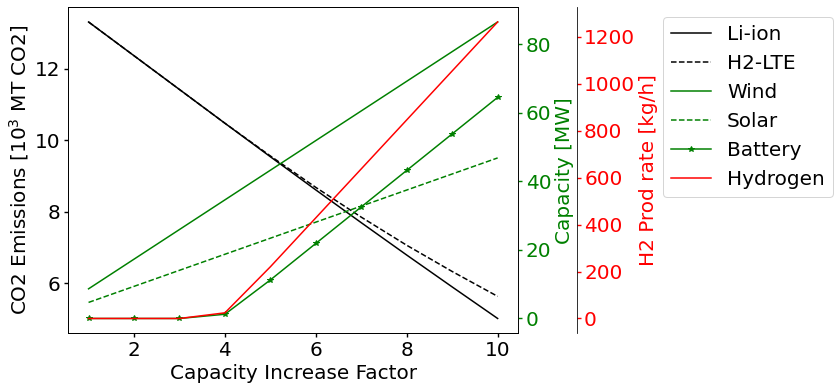

In [48]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.13))
# make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(np.arange(1, 11), battery_co2, 'k-', label='Li-ion')
p2, = host.plot(np.arange(1, 11), hydrogen_co2, 'k--', label='H2-LTE')

p3, = par1.plot(np.arange(1, 11), wind_cap, "g-", label="Wind")
p4, = par1.plot(np.arange(1, 11), solar_cap, "g--", label="Solar")
p5, = par1.plot(np.arange(1, 11), battery_cap, "g", marker='*', label="Battery")

p6, = par2.plot(np.arange(1, 11), hydrogen_rate, "r-", label="Hydrogen")

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.set_ylabel(r'CO2 Emissions [10$^3$ MT CO2]')
host.set_xlabel('Capacity Increase Factor')
par1.set_ylabel('Capacity [MW]')
par2.set_ylabel('H2 Prod rate [kg/h]')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p3.get_color())
par2.yaxis.label.set_color(p6.get_color())

tkw = dict(size=4, width=1.4)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p3.get_color(), **tkw)
par2.tick_params(axis='y', colors=p6.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3, p4, p5, p6]

# host.legend(lines, [l.get_label() for l in lines])
host.legend(lines, [l.get_label() for l in lines], loc='upper left', bbox_to_anchor=(1.3, 1.0))
plt.savefig('scenario1-summerA', dpi=300, bbox_inches="tight")
plt.show()

In [46]:
wind_cap[2], solar_cap[2]

(25.928999999999995, 14.04)

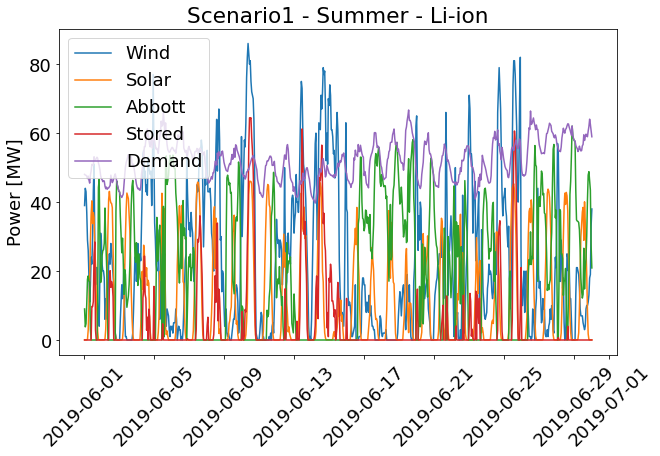

In [41]:
times = 10
eff = 0.85

solar4 = solar * times
wind4 = wind * times
abbott4 = demand - solar4 - wind4
#if (abbott4 <= 0).any():
#    print('We need a storage mechanism')

excess = abbott4.copy()
excess[excess > 0] = 0
abbott4[abbott4 < 0] = 0
excess *= -1
stored = np.roll(eff*excess, 1)
totalA = sum(abbott4)/0.6 * 0.26 * 0.907185

original_abbott4 = abbott4.copy()
original_stored = stored.copy()

for i in range(len(solar4)):
    if stored[i] > 0:
        if stored[i] <= abbott4[i]:
            abbott4[i] -= stored[i]
            stored[i] = 0
        else:
            if i < len(solar4)-1:
                stored[i] -= abbott4[i]
                stored[i+1] += stored[i]
                stored[i] = 0
            else:
                stored[i] -= abbott4[i]
            abbott4[i] = 0

plt.plot(index, wind4, label='Wind')
plt.plot(index, solar4, label='Solar')
plt.plot(index, abbott4, label='Abbott')
plt.plot(index, original_stored, label='Stored')
plt.plot(index, demand, label='Demand')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel('Power [MW]')
# plt.xlabel('Date')
plt.title('Scenario1 - Summer - Li-ion')
plt.savefig('scenario1-summerB', dpi=300, bbox_inches="tight")


# Scenario 2

# Let's add nuclear

In [547]:
def dispatch2_lte(times1, times2, eff, tout):
    solar2 = solar * times1
    wind2 = wind * times1
    reactor = 10 * times2  # MWth
    nuc_eff = h2.efficiency(tout)
    reactor_elec = nuc_eff * reactor  # MWe
    net_demand = demand - solar2 - wind2
    stored = np.zeros(len(net_demand))
    abbott2 = np.zeros(len(net_demand))

    for i in range(len(solar2)):
        if net_demand[i] > 0:
            if net_demand[i] > reactor_elec:
                abbott2[i] = net_demand[i] - reactor_elec
                if stored[i] <= abbott2[i]:
                    abbott2[i] -= stored[i]
                else:
                    stored[i] -= abbott2[i]
                    abbott2[i] = 0
                    stored[i+1] += stored[i]
                stored[i] = 0              
            else:
                stored[i+1] = eff*(reactor_elec - net_demand[i]) + stored[i]
                stored[i] = 0
                abbott2[i] = 0    
        else:
            stored[i+1] = eff*(reactor_elec - net_demand[i]) + stored[i]
            stored[i] = 0
            abbott2[i] = 0

    # print(f'Tot_demand: {sum(demand)} MW')
    # print(f'Tot_demand: {sum(abbott2.reshape(len(abbott2), 1) + solar2 + wind2 + reactor_elec*np.ones((len(wind2), 1)))} MW')

    co2 = sum(abbott2)/0.6 * 0.26 * 0.907185
    solar_max = 4.68*times1
    wind_max = 8.6*times1/100*100.5
    reactor_cap = reactor
    return co2


def dispatch2_hte(times1, times2, eff, tout):
    solar2 = solar * times1
    wind2 = wind * times1
    reactor = 10 * times2  # MWth
    p = 3.5
    p *= 9.86923  # MPa -> atm
    nuc_eff = h2.efficiency(tout)
    reactor_elec = nuc_eff * reactor  # MWe
    net_demand = demand - solar2 - wind2
    stored = np.zeros(len(net_demand))
    abbott2 = np.zeros(len(net_demand))

    for i in range(len(solar2)):
        if net_demand[i] > 0:
            if net_demand[i] > reactor_elec:
                abbott2[i] = net_demand[i] - reactor_elec
                if stored[i] <= abbott2[i]:
                    abbott2[i] -= stored[i]
                else:
                    stored[i] -= abbott2[i]
                    abbott2[i] = 0
                    stored[i+1] += stored[i]
                stored[i] = 0              
            else:
                # net_demand[i] < reactor_elec
                beta = net_demand[i]/reactor_elec
                h2prod2 = h2.hte_prod_rate((1.-beta)*reactor, p, tout)[0]
                elec = 0.6*40*h2prod2/1e3

                stored[i+1] = elec + stored[i]
                stored[i] = 0
                abbott2[i] = 0    
        else:
            # net_demand[i] < 0 
            beta = 0
            h2prod2 = h2.hte_prod_rate((1.-beta)*reactor, p, tout)[0]
            elec1 = 0.6*40*h2prod2/1e3
            excess2 = -1*net_demand[i]
            elec2 = eff*excess2
            stored[i+1] = elec1 + elec2 + stored[i]
            stored[i] = 0
            abbott2[i] = 0

    # print(f'Tot_demand: {sum(demand)} MW')
    # print(f'Tot_demand: {sum(abbott2.reshape(len(abbott2), 1) + solar2 + wind2 + reactor_elec*np.ones((len(wind2), 1)))} MW')

    co2 = sum(abbott2)/0.6 * 0.26 * 0.907185  # US tonnes to metric tons
    solar_max = 4.68*times1
    wind_max = 8.6*times1/100*100.5
    reactor_cap = reactor
    return co2

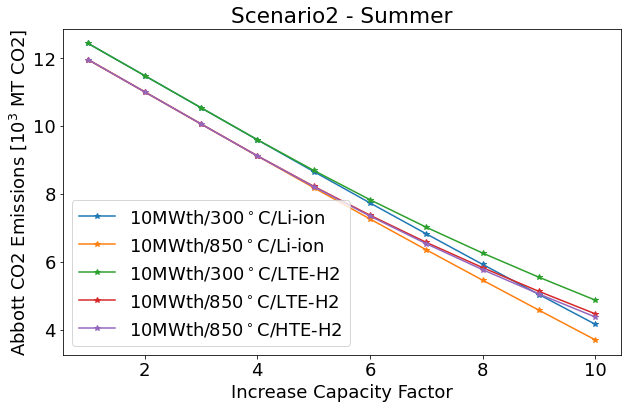

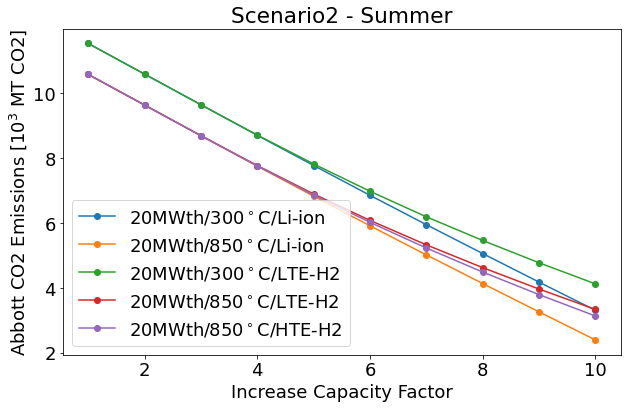

In [548]:
r1_battery1_co2 = []
r1_battery2_co2 = []
r1_lte1_co2 = []
r1_lte2_co2 = []
r1_hte_co2 = []

times2 = 1
for times1 in range(1, 11):
    # Battery 1
    co2 = dispatch2_lte(times1, times2, 0.85, 300)
    r1_battery1_co2.append(co2/1e3)
    # Battery 2
    co2 = dispatch2_lte(times1, times2, 0.85, 850)
    r1_battery2_co2.append(co2/1e3)
    # LTE 1
    co2 = dispatch2_lte(times1, times2, 0.4, 300)
    r1_lte1_co2.append(co2/1e3)
    # LTE 2
    co2 = dispatch2_lte(times1, times2, 0.4, 850)
    r1_lte2_co2.append(co2/1e3)
    # HTE 1
    co2 = dispatch2_hte(times1, times2, 0.4, 850)
    r1_hte_co2.append(co2/1e3)

r2_battery1_co2 = []
r2_battery2_co2 = []
r2_lte1_co2 = []
r2_lte2_co2 = []
r2_hte_co2 = []    
    
times2 = 2
for times1 in range(1, 11):
    # Battery 1
    co2 = dispatch2_lte(times1, times2, 0.85, 300)
    r2_battery1_co2.append(co2/1e3)
    # Battery 2
    co2 = dispatch2_lte(times1, times2, 0.85, 850)
    r2_battery2_co2.append(co2/1e3)
    # LTE 1
    co2 = dispatch2_lte(times1, times2, 0.4, 300)
    r2_lte1_co2.append(co2/1e3)
    # LTE 2
    co2 = dispatch2_lte(times1, times2, 0.4, 850)
    r2_lte2_co2.append(co2/1e3)
    # HTE 1
    co2 = dispatch2_hte(times1, times2, 0.4, 850)
    r2_hte_co2.append(co2/1e3)
    
plt.plot(np.arange(1, 11), r1_battery1_co2, marker='*', label=r'10MWth/300$^\circ$C/Li-ion')
plt.plot(np.arange(1, 11), r1_battery2_co2, marker='*', label=r'10MWth/850$^\circ$C/Li-ion')
plt.plot(np.arange(1, 11), r1_lte1_co2, marker='*', label=r'10MWth/300$^\circ$C/LTE-H2')
plt.plot(np.arange(1, 11), r1_lte2_co2, marker='*', label=r'10MWth/850$^\circ$C/LTE-H2')
plt.plot(np.arange(1, 11), r1_hte_co2, marker='*', label=r'10MWth/850$^\circ$C/HTE-H2')
plt.legend(loc='lower left')
plt.ylabel(r'Abbott CO2 Emissions [10$^3$ MT CO2]')
plt.xlabel('Increase Capacity Factor')
plt.title('Scenario2 - Summer')
plt.savefig('report/scenario2-summerA', dpi=300, bbox_inches="tight")

plt.figure()
plt.plot(np.arange(1, 11), r2_battery1_co2, marker='o', label=r'20MWth/300$^\circ$C/Li-ion')
plt.plot(np.arange(1, 11), r2_battery2_co2, marker='o', label=r'20MWth/850$^\circ$C/Li-ion')
plt.plot(np.arange(1, 11), r2_lte1_co2, marker='o', label=r'20MWth/300$^\circ$C/LTE-H2')
plt.plot(np.arange(1, 11), r2_lte2_co2, marker='o', label=r'20MWth/850$^\circ$C/LTE-H2')
plt.plot(np.arange(1, 11), r2_hte_co2, marker='o', label=r'20MWth/850$^\circ$C/HTE-H2')
plt.legend(loc='lower left')
plt.ylabel(r'Abbott CO2 Emissions [10$^3$ MT CO2]')
plt.xlabel('Increase Capacity Factor')
plt.title('Scenario2 - Summer')
plt.savefig('report/scenario2-summerB', dpi=300, bbox_inches="tight")

In [ ]:
times1 = 10
times2 = 1
eff = 0.85
tout = 300

solar2 = solar * times1
wind2 = wind * times1
reactor = 10 * times2  # MWth
nuc_eff = h2.efficiency(tout)
reactor_elec = nuc_eff * reactor  # MWe
net_demand = demand - solar2 - wind2
stored = np.zeros(len(net_demand))
abbott2 = np.zeros(len(net_demand))

storage = net_demand - reactor_elec
storage[storage > 0] = 0
storage *= -1
original_stored = np.roll(eff*storage, 1)

for i in range(len(solar2)):
    if net_demand[i] > 0:
        if net_demand[i] > reactor_elec:
            abbott2[i] = net_demand[i] - reactor_elec
            if stored[i] <= abbott2[i]:
                abbott2[i] -= stored[i]
            else:
                stored[i] -= abbott2[i]
                abbott2[i] = 0
                stored[i+1] += stored[i]
            stored[i] = 0              
        else:
            stored[i+1] = eff*(reactor_elec - net_demand[i]) + stored[i]
            stored[i] = 0
            abbott2[i] = 0    
    else:
        stored[i+1] = eff*(reactor_elec - net_demand[i]) + stored[i]
        stored[i] = 0
        abbott2[i] = 0



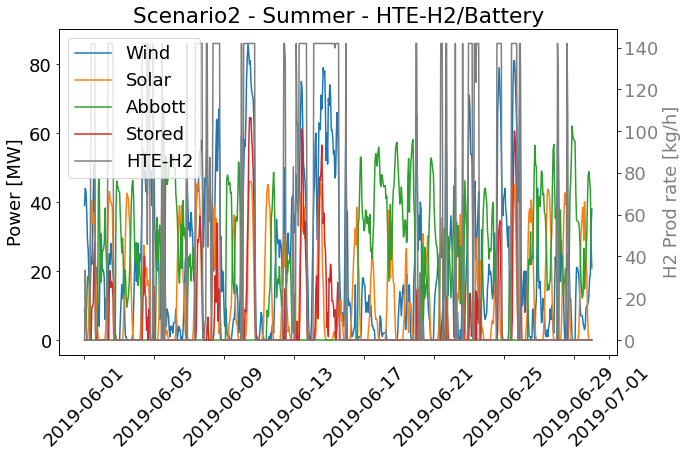

In [555]:
times1 = 10
times2 = 1
eff = 0.85
tout = 850

solar2 = solar * times1
wind2 = wind * times1
reactor = 10 * times2  # MWth
p = 3.5
p *= 9.86923  # MPa -> atm
nuc_eff = h2.efficiency(tout)
reactor_elec = nuc_eff * reactor  # MWe
net_demand = demand - solar2 - wind2
stored = np.zeros(len(net_demand))
abbott2 = np.zeros(len(net_demand))

storage = net_demand.copy()
storage[storage > 0] = 0
storage *= -1
original_stored = np.roll(eff*storage, 1)

h2prod2 = np.zeros(len(storage))

for i in range(len(solar2)):
    if net_demand[i] > 0:
        if net_demand[i] > reactor_elec:
            abbott2[i] = net_demand[i] - reactor_elec
            if stored[i] <= abbott2[i]:
                abbott2[i] -= stored[i]
            else:
                stored[i] -= abbott2[i]
                abbott2[i] = 0
                stored[i+1] += stored[i]
            stored[i] = 0              
        else:
            # net_demand[i] < reactor_elec
            beta = net_demand[i]/(nuc_eff * reactor)
            h2prod2[i] = h2.hte_prod_rate((1.-beta)*reactor, p, tout)[0]
            elec = 0.6*40*h2prod2[i]/1e3

            stored[i+1] = elec + stored[i]
            stored[i] = 0
            abbott2[i] = 0    
    else:
        # net_demand[i] < 0 
        beta = 0
        h2prod2[i] = h2.hte_prod_rate((1.-beta)*reactor, p, tout)[0]
        elec1 = 0.6*40*h2prod2[i]/1e3
        excess2 = -1*net_demand[i]
        elec2 = eff*excess2
        stored[i+1] = elec1 + elec2 + stored[i]
        stored[i] = 0
        abbott2[i] = 0

fig, ax1 = plt.subplots()
color = 'black'
l1 = ax1.plot(index, wind4, label='Wind')
l2 = ax1.plot(index, solar4, label='Solar')
l3 = ax1.plot(index, abbott4, label='Abbott')
l4 = ax1.plot(index, original_stored, label='Stored')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Power [MW]', color=color)
# ax1.set_xlabel('Increase Capacity Factor')
ax1.tick_params(axis='x', labelrotation=45)
# plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:gray'
l5 = ax2.plot(index, h2prod2, label='HTE-H2', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('H2 Prod rate [kg/h]', color=color)

# added these three lines
lns = l1+l2+l3+l4+l5
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')

plt.title('Scenario2 - Summer - HTE-H2/Battery')
plt.savefig('report/scenario2-summerD', dpi=300, bbox_inches="tight")
